In [1]:
import cvxpy as cp
import pandas as pd

You can download the stocks data from [here](https://calmcode.io/datasets.html).

In [2]:
df_stocks = pd.read_csv("stocks.csv").iloc[500:1800]
df_stocks

,Date,MSFT,KLM,ING,MOS
500,2002-01-18,21.53,0.25,13.96,10.22
501,2002-01-22,21.37,0.23,14.43,10.01
502,2002-01-23,20.55,0.20,14.32,10.05
503,2002-01-24,20.56,0.20,14.49,10.53
504,2002-01-25,20.59,0.20,14.23,10.53
...,...,...,...,...,...
1795,2007-03-14,20.00,0.28,28.34,22.00
1796,2007-03-15,20.37,0.28,28.05,22.19
1797,2007-03-16,20.39,0.28,28.37,21.96
1798,2007-03-19,20.38,0.27,28.93,22.14


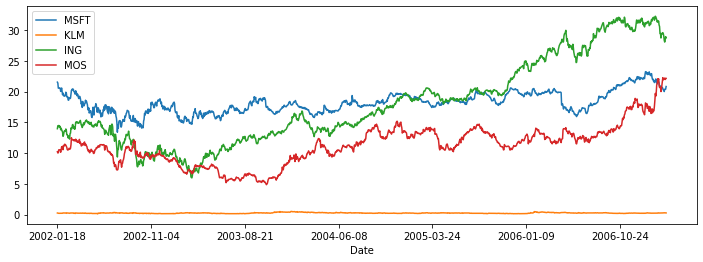

In [3]:
df_stocks.set_index('Date').plot(figsize=(12, 4));

In [4]:
df_returns = df_stocks.set_index('Date').diff()
mean_stock = df_returns.mean().values

In [5]:
cov_stock = df_returns.cov().values

For reference, this is what we need to put into `cvxpy`.

$$ \max \mu^Tx - p x^T C x$$ 

The full formula for the sum of weighted variables can be found [here](https://en.wikipedia.org/wiki/Variance#Weighted_sum_of_variables). 

In [6]:
x = cp.Variable(len(mean_stock))

stock_return = mean_stock * x
stock_risk = cp.quad_form(x, cov_stock)
p = 1 

objective = cp.Maximize(stock_return - p * stock_risk)
constraints = [x >= 0, cp.sum(x) == 1]
prob = cp.Problem(objective=objective, constraints=constraints)
prob.solve(), x.value

(6.289347782495393e-05,
 array([-1.46749056e-23,  9.00502860e-01,  4.98638391e-02,  4.96333004e-02]))

## Towards Plotting 

Let's now put this into a function so we can repeat it.

In [7]:
def solve_problem(dataf, risk_pref=0.1):
    mean_stock = dataf.diff().mean().values
    cov_stock = dataf.diff().cov().values
    
    x = cp.Variable(len(mean_stock))

    stock_return = mean_stock.T * x
    stock_risk = cp.quad_form(x, cov_stock)

    objective = cp.Maximize(stock_return - risk_pref * stock_risk)
    constraints = [cp.sum(x) == 1, x >= 0]
    prob = cp.Problem(objective=objective, constraints=constraints)
    return prob.solve(), x.value

In [8]:
import numpy as np
import matplotlib.pylab as plt 

steps = np.linspace(0.01, 2, 100)
x_vals = np.zeros((steps.shape[0], 4))
profit = np.zeros(steps.shape[0])
for i, r in enumerate(steps):
    p, xs = solve_problem(df_stocks.set_index('Date'), risk_pref=r)
    x_vals[i, :] = xs
    profit[i] = p

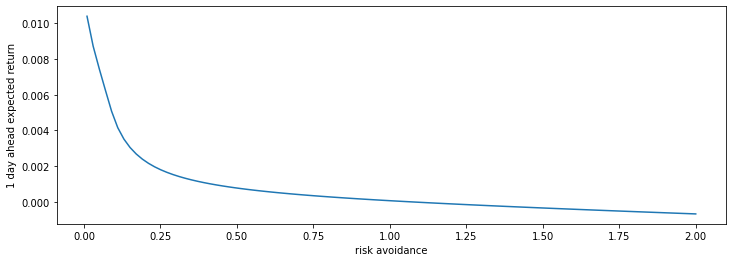

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(steps, profit)
plt.xlabel("risk avoidance")
plt.ylabel("1 day ahead expected return");

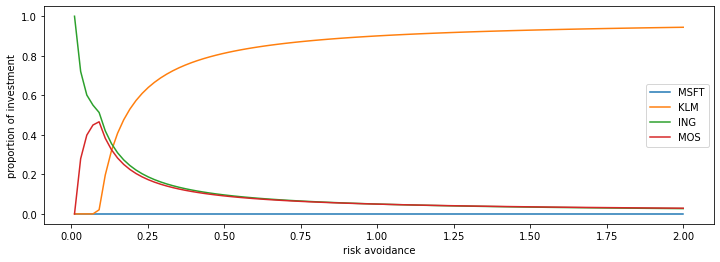

In [10]:
plt.figure(figsize=(12, 4))
tickers = ["MSFT", "KLM", "ING", "MOS"]
for idx, stock in enumerate(tickers):
    plt.plot(steps, x_vals[:, idx], label=stock)
plt.xlabel("risk avoidance")
plt.ylabel("proportion of investment")
plt.legend();

## Over Time Now 

Now a similar thing but with the dates.

In [11]:
from tqdm import tqdm

def make_dataf_generator(dataf, window=90, step=5):
    i = 0
    while i*step+window < len(dataf):
        subset = dataf.iloc[0 + i*step:window+i*step]
        yield subset.index[-1], subset
        i += 1

In [12]:
df = pd.read_csv("stocks.csv").assign(Date = lambda d: pd.to_datetime(d['Date']))

subset_df = (df
             .loc[lambda d: d['Date'] < pd.to_datetime('2010-01-01')]
             .set_index('Date'))
groups = make_dataf_generator(subset_df)


x_vals = []
profit = []
timestamps = []
for ts, g in tqdm(groups):
    p, xs = solve_problem(g, risk_pref=1.5)
    timestamps.append(ts)
    x_vals.append(xs)
    profit.append(p)

480it [00:03, 123.97it/s]


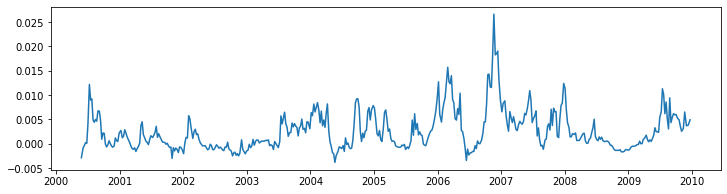

In [13]:
plt.figure(figsize=(12, 3))
plt.plot(timestamps, profit);

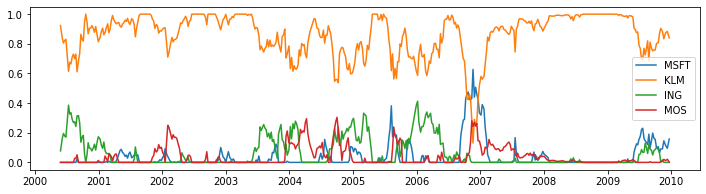

In [14]:
plt.figure(figsize=(12, 3))
x_vals = np.array(x_vals)
for idx, stock in enumerate(tickers):
    plt.plot(timestamps, x_vals[:, idx], label=stock)
plt.legend();

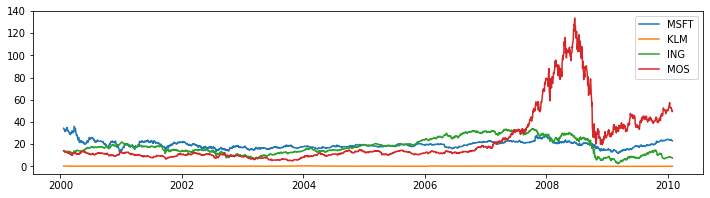

In [15]:
plt.figure(figsize=(12, 3))
plot_df = df.head(2500)
for idx, stock in enumerate(tickers):
    plt.plot(plot_df['Date'], plot_df[stock], label=stock)
plt.legend();